# Vehicle Detection

This project will demonstrate how I setup pipeline to detect the vehicle so I will start from a sample images and along the way I will apply that to a series of images or video. 

At the end you will see the video with vehicle detection.

Let walk through the steps

* Explore data
* Choose color features
* Choose gradient features based with HOG
* Train classifiers to detect cars and non-cars
* Implement sliding windows to scan the images
* Apply pipeline to video streams and tracking to follow the vehicles

## Let explore the data

Let look at training data we're going to use to build the classifier.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import vehicle_detection as my_function 
import glob
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%load_ext autoreload
%autoreload 2

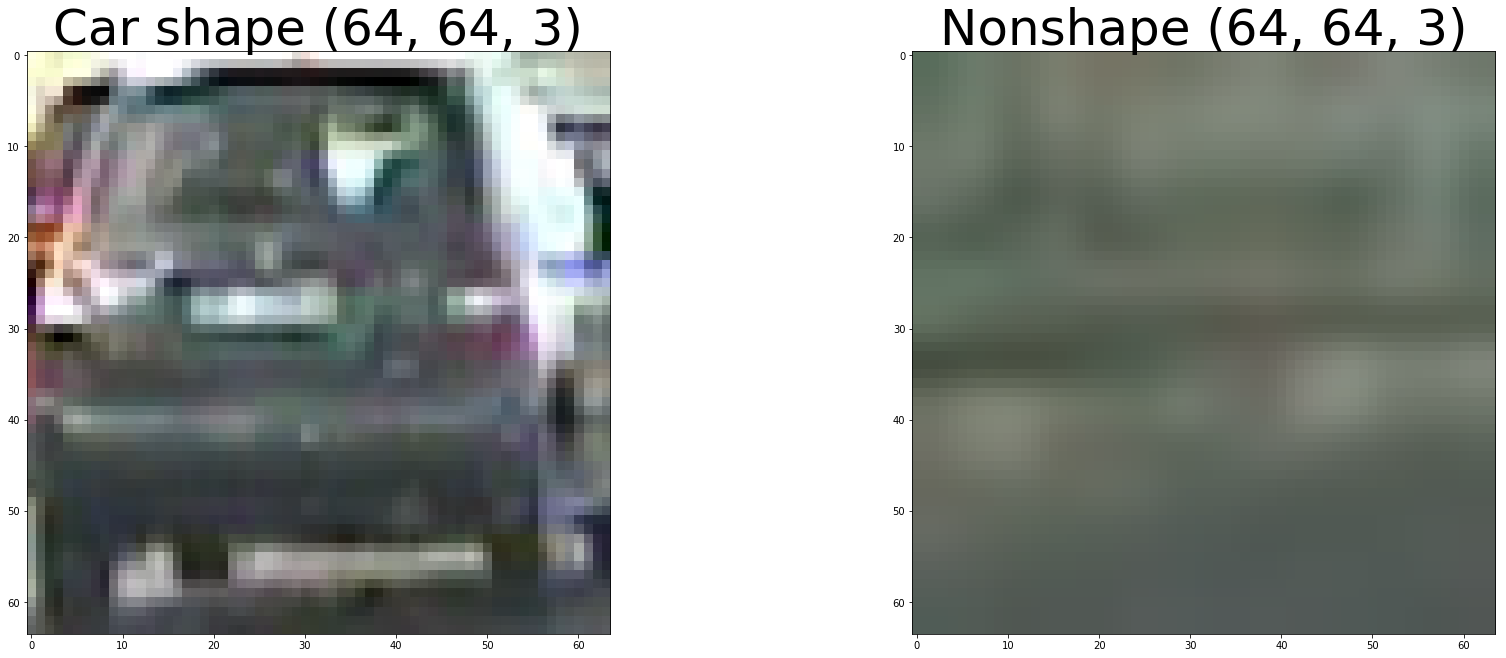

In [2]:
img1 = my_function.read_image('./test_images/car_1.png')
img2 = my_function.read_image('./test_images/noncar_1.png')
my_function.display_2_images(img1, img2, 
                             text_1='Car shape {}'.format(img1.shape), 
                             text_2='Nonshape {}'.format(img2.shape))

## Color Features

* Spatial Binning of Color
* Histogram of Color

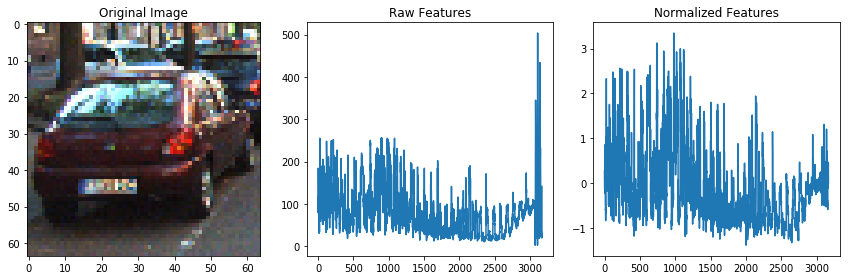

In [3]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)                
        
car_features = my_function.extract_features(cars, color_space='RGB', 
                        spatial_size=(32, 32),hist_bins=32, 
                        spatial_feat=True, hist_feat=True, hog_feat=False)
notcar_features = my_function.extract_features(notcars, color_space='RGB', 
                        spatial_size=(32, 32),hist_bins=32, 
                        spatial_feat=True, hist_feat=True, hog_feat=False)   

X = np.vstack([car_features, notcar_features]).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## HOG Feature

/Users/ouan/myworkspace/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


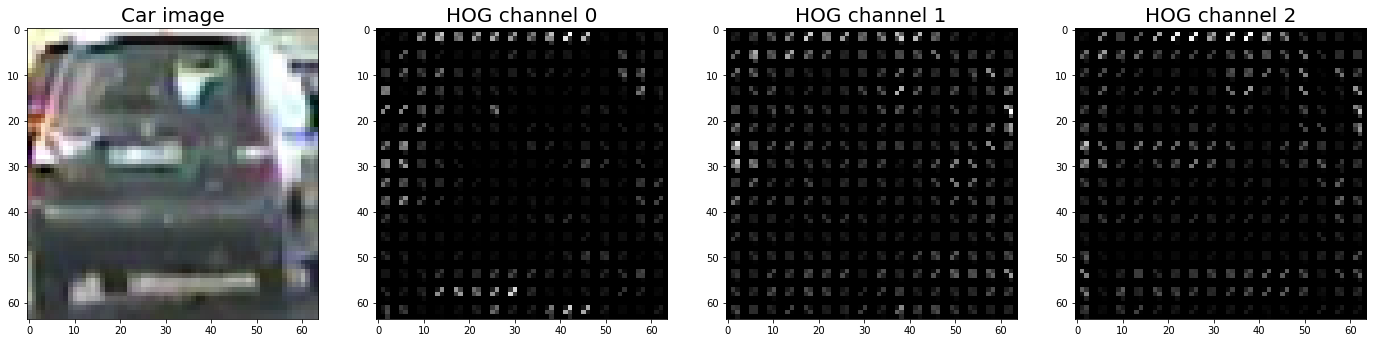

In [7]:
car_image = my_function.read_image('./test_images/car_1.png')
car_image_hsv = cv2.cvtColor(car_image, cv2.COLOR_RGB2HSV)

f, (*ax) = plt.subplots(1, 4, figsize=(24, 9))
ax[0][0].imshow(car_image)
ax[0][0].set_title("Car image", fontsize=20)
for i in range(3):
    hog_features, img_feature = my_function.get_hog_features(car_image_hsv[:,:,i], orient=25,
                        pix_per_cell=4, cell_per_block=2, vis=True, feature_vec=False)   
    ax[0][i+1].imshow(img_feature, cmap='gray')
    ax[0][i+1].set_title("HOG channel {}".format(i), fontsize=20)    


/Users/ouan/myworkspace/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


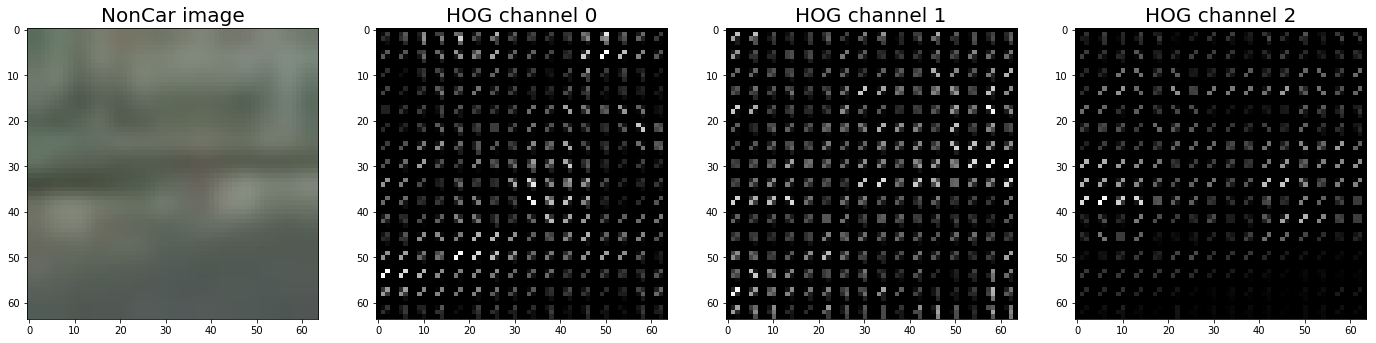

In [8]:
noncar_image = my_function.read_image('./test_images/noncar_1.png')
noncar_image_hsv = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2HSV)

f, (*ax) = plt.subplots(1, 4, figsize=(24, 9))
ax[0][0].imshow(noncar_image)
ax[0][0].set_title("NonCar image", fontsize=20)
for i in range(3):
    hog_features, img_feature = my_function.get_hog_features(noncar_image_hsv[:,:,i], orient=25,
                        pix_per_cell=4, cell_per_block=2, vis=True, feature_vec=False)   
    ax[0][i+1].imshow(img_feature, cmap='gray')
    ax[0][i+1].set_title("HOG channel {}".format(i), fontsize=20)    

/Users/ouan/myworkspace/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


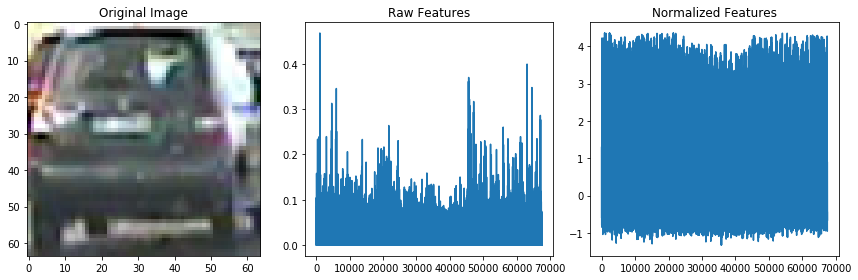

In [10]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = my_function.extract_features(cars, color_space='HSV', 
                        orient=25,
                        pix_per_cell=4, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)
notcar_features = my_function.extract_features(notcars, color_space='HSV', 
                        orient=25,
                        pix_per_cell=4, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)

X = np.vstack([car_features, notcar_features]).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### Sliding Windows

In this step, we have classifiers with optimum features we choose from above experiments.

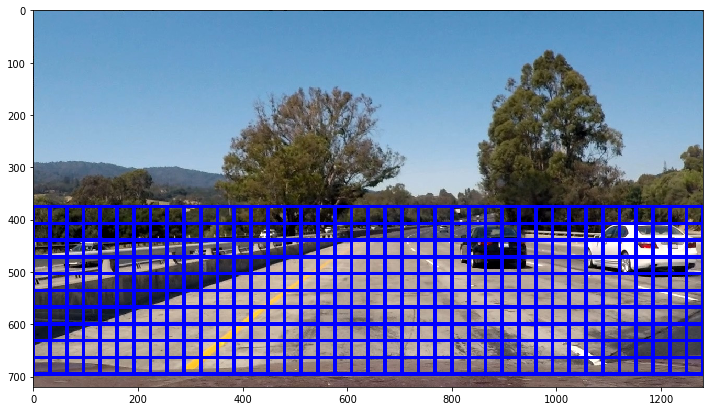

In [21]:
test_image = my_function.read_image('./test_images/test1.jpg')
window_list = my_function.slide_window(test_image,y_start_stop=[375,None])
window_image = my_function.draw_boxes(test_image, window_list)
plt.figure(figsize=(12,12))
plt.imshow(window_image)